In [1]:
report_date = '2021-04-12 11:00:00'

In [2]:
import pandas as pd
import pymssql
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.optimize import curve_fit
import datetime

In [3]:
def ms_sql_con():
    sql_name = 'voice_ai'
    sql_server = '10.2.4.124'
    sql_login = 'ICECORP\\1c_sql'

    with open('sql.pass','r') as file:
        sql_pass = file.read().replace('\n', '')
        file.close()

    return pymssql.connect(
            server = sql_server,
            user = sql_login,
            password = sql_pass,
            database = sql_name,
            # autocommit=True
        )

In [4]:
def read_sql(query):
    return pd.read_sql(query, con=ms_sql_con(), parse_dates=None)

In [5]:
def spent_time_vs_duration():
    print('spent time vs audio record duration')    
    df.plot(x="duration", y=["time"],  kind="scatter", colors = df['color'])
    plt.show()

In [6]:
def spent_time_vs_date():
    print('spent time on timeline')
    df['time_int'] = pd.to_timedelta(df.event_date).dt.total_seconds().astype(int)
    df['time_int'] = df['time_int'] - df.time_int.min()
    df.plot(x="time_int", y=["time"],  kind="scatter", colors = df['color'])
    plt.show()

In [7]:
def coef():
    x_train = np.array(df.duration).reshape(-1, 1)
    y_train = np.array(df.time).reshape(-1, 1)
    model = LinearRegression().fit(x_train, y_train)
    y_pred = model.predict(x_train)
    plt.scatter(x_train, y_train,  color='gray')
    plt.plot(x_train, y_pred, color='red', linewidth=2)
    plt.show()
    print('linear regression coef', model.coef_)
    return model.coef_[0][0]

In [8]:
def performance():
    
   
    print('performance: seconds of recognized audio per 10 min')
    counter = [0 for _ in range(int(df.time_int.max()/600))]
    
    for index, row in df.iterrows():
        cell = int(row.time_int/600)
        if len(counter) < cell + 1:
            counter.append(0)
        counter[cell] += row.duration   

    counter.insert(0,0)
    counter.pop(len(counter) - 1)
    plt.plot([x for x in range(len(counter))], counter, 'o', color='red', linewidth=2)
    plt.show()
    print([int(c) for c in counter])

In [9]:
def perf_cores():

    print('performance by cores count:')
    
    df['time_int'] = pd.to_timedelta(df.event_date).dt.total_seconds().astype(int)
    df['time_int'] = df['time_int'] - df.time_int.min()

    counter = [[] for _ in range(int(df.time_int.max()/600))]

    for index, row in df.iterrows():
        cell = int(row.time_int/600)
        if len(counter) < cell + 1:
            counter.append([])
        counter[cell].append(row.cores)

    cores = np.nan_to_num( [np.mean(c) for c in counter] )

    counter = [0 for _ in range(int(df.time_int.max()/600))]

    for index, row in df.iterrows():
        cell = int(row.time_int/600)
        if len(counter) < cell + 1:
            counter.append(0)
        counter[cell] += row.duration   

    counter.insert(0,0)
    counter.pop(len(counter) - 1)
    
    pc = pd.DataFrame([cores, counter]).T
    pc.columns = ['cores', 'time']
    pc = pd.DataFrame(pc.groupby('cores').mean())
    pc.reset_index(level=0, inplace=True)
    
    plt.plot(pc.cores, pc.time, 'o', color='red', linewidth=2)
    plt.show()

In [10]:
def cores_to_performance_calculated(report_date):
    
    print('cores count performance calculated:')
    
    query = "select cores, time, duration"
    query += " from perf_log "
    query += " where step = 2 and event_date > '"+report_date+"' and time > 5;"
    df = read_sql()
    df['td'] = df.time/df.duration
    df['perf'] = df.time/df.duration/df.cores
    df.drop(['duration','time'], axis=1, inplace=True)

    #meantd = df.groupby(df.cores).mean()
    #meantd.reset_index(level=0, inplace=True)
    #plt.plot(meantd.cores, meantd.td, 'o')

    #mediantd = df.groupby(df.cores).median()
    #mediantd.reset_index(level=0, inplace=True)
    #plt.plot(mediantd.cores, mediantd.td, 'o')

    mediantd = df.groupby(df.cores).median()
    mediantd.reset_index(level=0, inplace=True)
    plt.plot(mediantd.cores, mediantd.perf, 'o')

In [11]:
def reco_prognose():
    query = "select sum(duration) from queue"
    df_queued = pd.read_sql(query, con=ms_sql_con())
    queued_duration = float(df_queued.iloc[0])
    time_prognose = queued_duration * performance_coef
    print('recognize time prognose:', int(time_prognose), 'sec')
    print('or', int(time_prognose/60), 'min')
    print('or', int(time_prognose/60/60), 'h')
    print('or', int(time_prognose/60/60/24), 'd')

In [12]:
def colorator(source_id):
    return 'red' if source_id == 1 else 'green'

In [13]:
def earliest_records():
    print('earliest records')
    query = "select source_id, min(record_date) from queue group by source_id order by source_id;"
    df_queued = pd.read_sql(query, con=ms_sql_con())
    print(df_queued)

In [14]:
#query = "select event_date, cpu, time, duration from perf_log where step = 1 and duration<400 and time > 1000;"
#query = "select cpu, count(cpu) as cnt, sum(time) as time_sum from perf_log where step = 2 and time > 1000 group by cpu order by cpu;"
#query = "select event_date, time as time_sum from perf_log where step = 2 and cpu = 3 order by event_date;"

In [15]:
def plot_cpu_usage():
    df.groupby(['cpu']).sum().plot(y = ['time'], kind="bar")

In [16]:
def queue_time_vs_date():
    queue['color'] = queue['source_id'].apply(colorator)
    
    q_a = queue[queue.source_id == 1]
    q_b = queue[queue.source_id == 2]
    
    ratio = max(queue.queued_seconds_from_now) / max(queue.recorded_seconds_from_now) * 10
    fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=80)
    
    ax.scatter(
        q_a.queued_seconds_from_now, 
        q_a.recorded_seconds_from_now, 
        color=q_a['color'],
        label="call",
         marker = 'x'
    )
    ax.scatter(
        q_b.queued_seconds_from_now, 
        q_b.recorded_seconds_from_now, 
        color=q_b['color'],
        label="mrm",
        marker = '.'
    )
    currentdate = datetime.datetime.today()
    currentdate = currentdate.strftime('%Y.%m.%d %H:%M:%S')
    #datetime.datetime.strptime(df, f_0).strftime(f_1)
    ax.set_title('Очередь ' + currentdate, fontsize=18)

    # Set common labels
    ax.set_xlabel('Добавлено, сек. назад', fontsize=18)
    ax.set_ylabel('Записано, сек. назад', fontsize=18)
    
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.savefig('queue.png')

spent time vs audio record duration


/home/alex/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


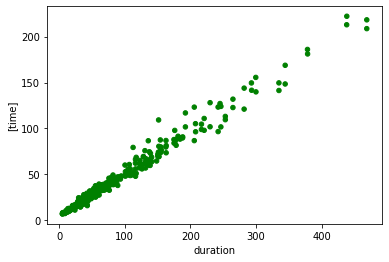

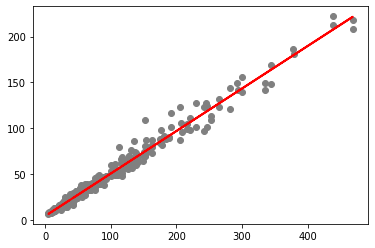

linear regression coef [[0.46381123]]
spent time on timeline


/home/alex/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)
/home/alex/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


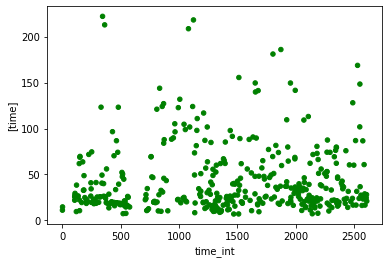

performance: seconds of recognized audio per 10 min


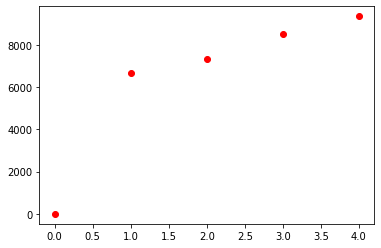

[0, 6658, 7321, 8522, 9346]
performance by cores count:


/home/alex/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


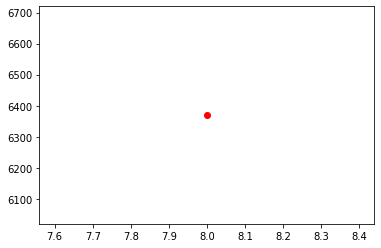

recognize time prognose: 382666 sec
or 6377 min
or 106 h
or 4 d
earliest records
   source_id                    
0          1 2021-04-09 07:31:52
1          2 2021-04-12 11:23:16


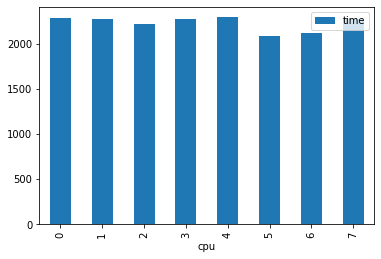

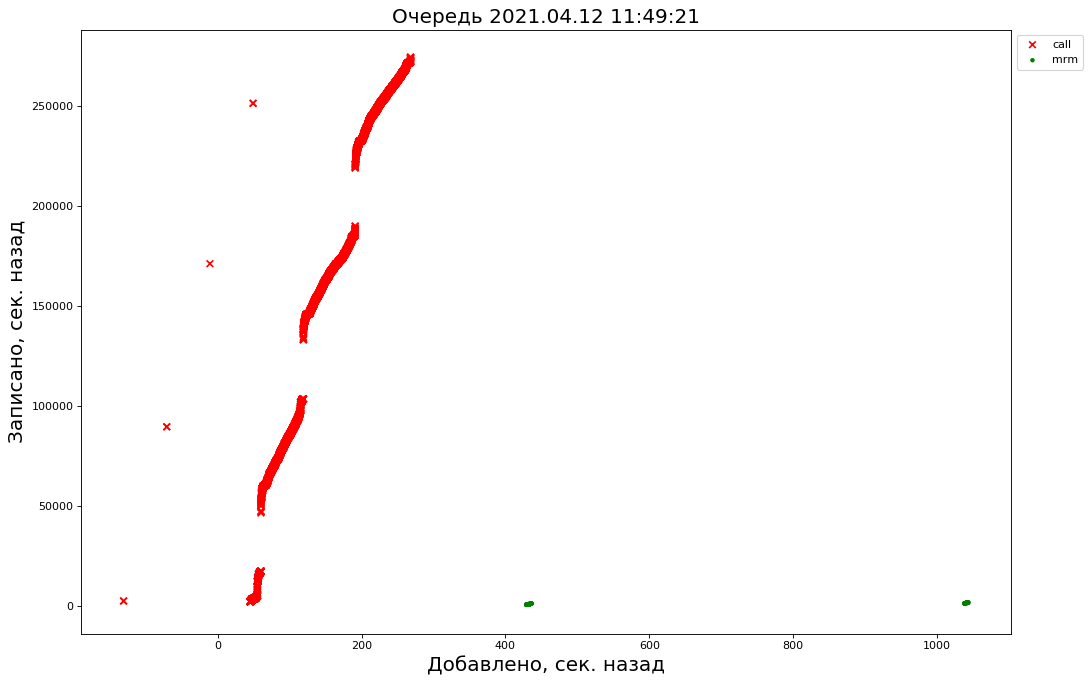

In [17]:
query = "select event_date, cpu, time, duration, source_id, cores"
query += " from perf_log "
#query += " where cores = 9 and step = 2 and event_date > '2021-03-12 15:27:00' and time > 5;"
query += " where step = 2 and event_date > '"+report_date+"' and time > 5;"
df = read_sql(query)
df['color'] = df['source_id'].apply(colorator)
spent_time_vs_duration()
performance_coef = coef()
#print('9 cores')
spent_time_vs_date()
performance()
perf_cores()
plot_cpu_usage()
reco_prognose()
earliest_records()

query = "select"
query += " source_id,"
query += " DATEDIFF(second, date, getdate()) as queued_seconds_from_now,"
query += " DATEDIFF(second, record_date, getdate()) as recorded_seconds_from_now"
query += " from queue order by record_date;"
queue = read_sql(query)
queue_time_vs_date()

In [18]:
#cores_to_performance_calculated()

In [19]:
# queue
query = "SELECT column_name FROM information_schema.columns WHERE table_name='queue';"
queue = read_sql(query)
queue

,column_name
0,date
1,cpu_id
2,filepath
3,date_y
4,date_m
5,date_d
6,filename
7,duration
8,record_date
9,source_id


In [21]:
query = "SELECT version, filename FROM queue order by record_date desc;"
queue = read_sql(query)
queue

,version,filename
0,1,a2021-04-12t11:42:00b_c9773540238d_e8926875147...
1,1,a2021-04-12t11:42:00b_c9773540238d_e8926875147...
2,1,a2021-04-12t11:41:43b_c9689595864d_e8964529217...
3,1,a2021-04-12t11:41:43b_c9689595864d_e8964529217...
4,1,a2021-04-12t11:41:36b_c9267369966d_e8916802053...
...,...,...
6768,0,in_79143428216_2021-04-09-07-38-32rxtx.wav
6769,0,in_79309419718_2021-04-09-07-37-35rxtx.wav
6770,0,in_9057334008_2021-04-09-07-35-23rxtx.wav
6771,0,in_79081794748_2021-04-09-07-33-48rxtx.wav
